In [ ]:
# https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-ms.html#Setup-Instructions

In [ ]:
# pip install planetary-computer

In [2]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load

In [3]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42281 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42281/status,
Dashboard: http://127.0.0.1:42281/status,Workers: 4
Total threads: 16,Total memory: 15.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45799,Workers: 4
Dashboard: http://127.0.0.1:42281/status,Total threads: 16
Started: Just now,Total memory: 15.35 GiB
Comm: tcp://127.0.0.1:33291,Total threads: 4
Dashboard: http://127.0.0.1:43741/status,Memory: 3.84 GiB
Nanny: tcp://127.0.0.1:33565,


### Query STAC API

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [5]:
query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2019-06",
    query={"s2:mgrs_tile": dict(eq="06VVN")},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 23 datasets


### Lazy load all the bands

In [6]:
resolution = 10
SHRINK     = 4

if client.cluster.workers[0].memory_manager.memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

In [7]:
xx = stac_load(
    items,
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 6GB
Dimensions:      (y: 2745, x: 2745, time: 23)
Coordinates:
  * y            (y) float64 22kB 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 22kB 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 4B 32606
  * time         (time) datetime64[ns] 184B 2019-06-01T21:15:21.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [8]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir,SCL


<xarray.Dataset> Size: 2GB
Dimensions:      (y: 2745, x: 2745, time: 23)
Coordinates:
  * y            (y) float64 22kB 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 22kB 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 4B 32606
  * time         (time) datetime64[ns] 184B 2019-06-01T21:15:21.024000 ... 20...
Data variables:
    red          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint16 347MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

### Do some math with bands

In [9]:
def to_float(xx):
    _xx = xx.astype("float32")
    nodata = _xx.attrs.pop("nodata", None)
    if nodata is None:
        return _xx
    return _xx.where(xx != nodata)


def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

In [ ]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir  = to_float(xx.nir)
red  = to_float(xx.red)
ndvi = (nir - red) / (nir + red) # < This is still a lazy Dask computation (no data loaded yet)

/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


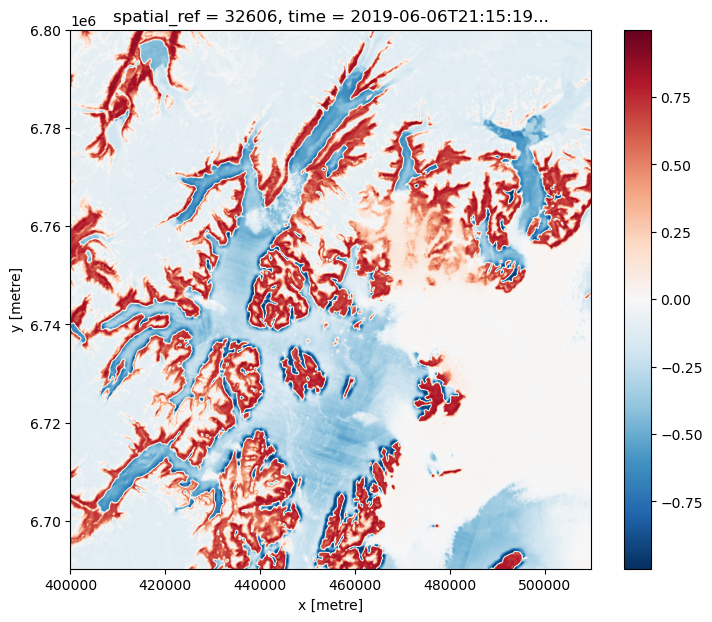

In [11]:
# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

In [12]:
xx = xx.isel(time=np.s_[:6])

/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


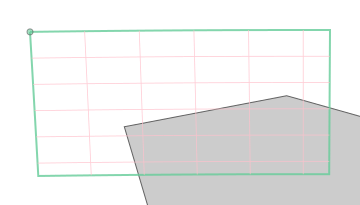

In [13]:
# fmt: off
scl_colormap = np.array(
    [
        [255,   0, 255, 255],  # 0  - NODATA
        [255,   0,   4, 255],  # 1  - Saturated or Defective
        [0  ,   0,   0, 255],  # 2  - Dark Areas
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow
        [3  , 139,  80, 255],  # 4  - Vegetation
        [192, 132,  12, 255],  # 5  - Bare Ground
        [21 , 103, 141, 255],  # 6  - Water
        [117,   0,  27, 255],  # 7  - Unclassified
        [208, 208, 208, 255],  # 8  - Cloud
        [244, 244, 244, 255],  # 9  - Definitely Cloud
        [195, 231, 240, 255],  # 10 - Thin Cloud
        [222, 157, 204, 255],  # 11 - Snow or Ice
    ],
    dtype="uint8",
)
# fmt: on

# Load SCL band, then convert to RGB using color scheme above
scl_rgba = colorize(xx.SCL.compute(), scl_colormap)

# Check we still have geo-registration
scl_rgba.odc.geobox

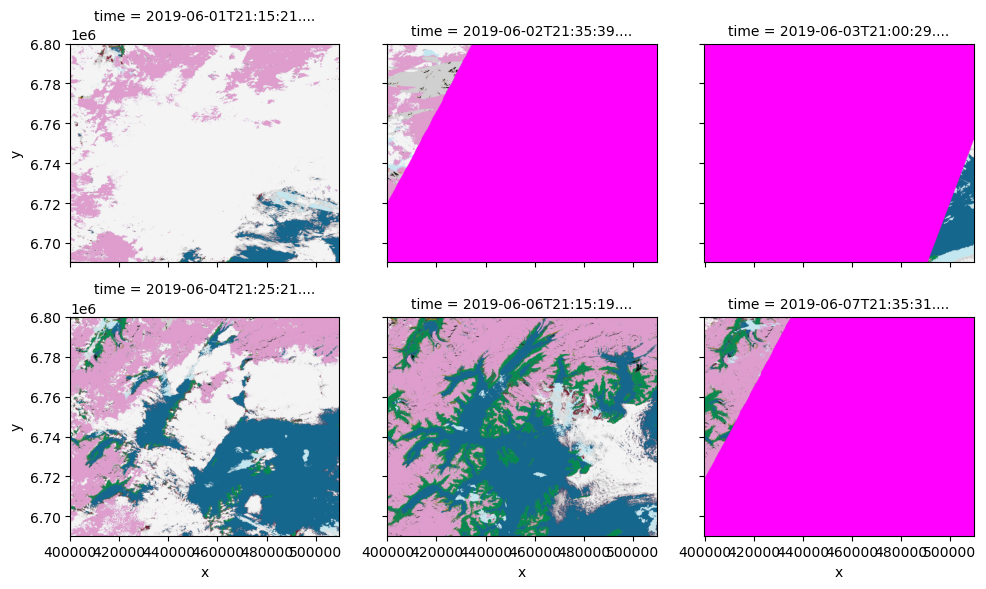

In [14]:
_ = scl_rgba.plot.imshow(col="time", col_wrap=3, size=3, interpolation="antialiased")

In [ ]:
to_save      = scl_rgba.isel(time=3)
local_prefix = "prefix"
fname        = f"{local_prefix}/SCL-{to_save.time.dt.strftime('%Y%m%d').item()}.tif"
print(f"Saving to: '{fname}'")

Saving to: 'prefix/SCL-20190604.tif'


In [18]:
scl_rgba.isel(time=3).odc.write_cog(
    fname,
    overwrite=True,
    compress="webp",
    webp_quality=90,
)

PosixPath('prefix/SCL-20190604.tif')

In [20]:
!ls -lh {fname}
!rio info {fname} | jq .

-rw-rw-r-- 1 apolo apolo 1,4M abr 21 19:35 prefix/SCL-20190604.tif
{
  "blockxsize": 512,
  "blockysize": 512,
  "bounds": [
    399960,
    6690240,
    509760,
    6800040
  ],
  "colorinterp": [
    "red",
    "green",
    "blue",
    "alpha"
  ],
  "compress": "webp",
  "count": 4,
  "crs": "EPSG:32606",
  "descriptions": [
    null,
    null,
    null,
    null
  ],
  "driver": "GTiff",
  "dtype": "uint8",
  "height": 2745,
  "indexes": [
    1,
    2,
    3,
    4
  ],
  "interleave": "pixel",
  "lnglat": [
    -147.83041488908293,
    60.83899713274621
  ],
  "mask_flags": [
    [
      "per_dataset",
      "alpha"
    ],
    [
      "per_dataset",
      "alpha"
    ],
    [
      "per_dataset",
      "alpha"
    ],
    [
      "all_valid"
    ]
  ],
  "nodata": null,
  "res": [
    40,
    40
  ],
  "shape": [
    2745,
    2745
  ],
  "tiled": true,
  "transform": [
    40,
    0,
    399960,
    0,
    -40,
    6800040,
    0,
    0,
    1
  ],
  "units": [
    null,
    null